# Imports

In [1]:
# go to repository root directory
import os
os.chdir("..")
os.environ['GEOMSTATS_BACKEND'] = 'pytorch'

# external 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
from geomstats.geometry.poincare_ball import PoincareBall
from Levenshtein import distance
from util.data_handling.data_loader import index_to_one_hot
from util.ml_and_math.layers import MLP
import torch.nn.functional as F
from util.distance_functions.distance_functions import DISTANCE_TORCH

# repository imports
from edit_distance.train import load_edit_distance_dataset
from util.data_handling.data_loader import get_dataloaders
from util.ml_and_math.loss_functions import AverageMeter

/home/gabriel/miniconda3/envs/neuroseed/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using pytorch backend


# NeuroSEED Classes

In [2]:
def train(model, loader, optimizer, loss, device):
    avg_loss = AverageMeter()
    model.train()

    for sequences, labels in loader:
        # move examples to right device
        sequences, labels = sequences.to(device), labels.to(device)

        # forward propagation
        optimizer.zero_grad()
        output = model(sequences)

        # loss and backpropagation
        loss_train = loss(output, labels)
        loss_train.backward()
        optimizer.step()

        # keep track of average loss
        avg_loss.update(loss_train.data.item(), sequences.shape[0])

    return avg_loss.avg


def test(model, loader, loss, device):
    avg_loss = AverageMeter()
    model.eval()

    for sequences, labels in loader:
        # move examples to right device
        sequences, labels = sequences.to(device), labels.to(device)

        # forward propagation and loss computation
        output = model(sequences)
        loss_val = loss(output, labels).data.item()
        avg_loss.update(loss_val, sequences.shape[0])

    return avg_loss.avg

In [3]:
class MLPEncoder(nn.Module):

    def __init__(self, len_sequence=152, embedding_size=128, layers=4, hidden_size=128, device=None, batch_norm=True, dropout=0.,
                 alphabet_size=4):
        super(MLPEncoder, self).__init__()

        self.encoder = MLP(in_size=alphabet_size * len_sequence, hidden_size=hidden_size, out_size=embedding_size,
                           layers=layers, mid_activation='relu', dropout=dropout, device=device, mid_b_norm=batch_norm)

    def forward(self, sequence):
        # flatten sequence
        B = sequence.shape[0]
        sequence = sequence.reshape(B, -1)

        # apply MLP
        emb = self.encoder(sequence)
        return emb
        
class PairEmbeddingDistance(nn.Module):

    def __init__(self, embedding_model, distance='euclidean', scaling=False):
        super(PairEmbeddingDistance, self).__init__()

        self.embedding_model = embedding_model
        self.distance = DISTANCE_TORCH[distance]
        self.distance_str = distance

        self.scaling = None
        if scaling:
            self.radius = nn.Parameter(torch.Tensor([1e-2]), requires_grad=True)
            self.scaling = nn.Parameter(torch.Tensor([1.]), requires_grad=True)

    def normalize_embeddings(self, embeddings):
        """ Project embeddings to an hypersphere of a certain radius """
        min_scale = 1e-7

        if self.distance_str == 'hyperbolic':
            max_scale = 1 - 1e-3
        else:
            max_scale = 1e10

        return F.normalize(embeddings, p=2, dim=1) * self.radius.clamp_min(min_scale).clamp_max(max_scale)

    def encode(self, sequence):
        """ Use embedding model and normalization to encode some sequences. """
        enc_sequence = self.embedding_model(sequence)
        if self.scaling is not None:
            enc_sequence = self.normalize_embeddings(enc_sequence)
        return enc_sequence

    def forward(self, sequence):
        # flatten couples
        (B, _, N, _) = sequence.shape
        sequence = sequence.reshape(2 * B, N, -1)

        # encode sequences
        enc_sequence = self.encode(sequence)

        # compute distances
        enc_sequence = enc_sequence.reshape(B, 2, -1)
        distance = self.distance(enc_sequence[:, 0], enc_sequence[:, 1])

        if self.scaling is not None:
            distance = distance * self.scaling

        return distance

In [4]:
EMBEDDING_SIZE = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(2021)
if device == 'cuda':
    torch.cuda.manual_seed(2021)

# load data
datasets = load_edit_distance_dataset('./edit_qiita_large.pkl')
loaders = get_dataloaders(datasets, batch_size=128, workers=1)

# model, optimizer and loss
encoder = MLPEncoder(device = device)
model = PairEmbeddingDistance(embedding_model=encoder, distance='hyperbolic')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()

# training
for epoch in range(0, 2):
    t = time.time()
    loss_train = train(model, loaders['train'], optimizer, loss, device)
    loss_val = test(model, loaders['val'], loss, device)

    # print progress
    if epoch % 1 == 0:
        print('Epoch: {:02d}'.format(epoch),
              'loss_train: {:.6f}'.format(loss_train),
              'loss_val: {:.6f}'.format(loss_val),
              'time: {:.4f}s'.format(time.time() - t))
      
# testing
for dset in loaders.keys():
    avg_loss = test(model, loaders[dset], loss, device)
    print('Final results {}: loss = {:.6f}'.format(dset, avg_loss))

Epoch: 00 loss_train: 0.015848 loss_val: 0.004663 time: 13.8170s
Epoch: 01 loss_train: 0.003802 loss_val: 0.003846 time: 13.1649s
Final results train: loss = 0.003382
Final results val: loss = 0.003846
Final results test: loss = 0.004087


# Prepare data

In [5]:
'''
    Gets the concatenated matrix of sequences
        and matrix of test sequences.
'''
def get_concat_test_sequences():

    # open pkl file
    with open('./edit_qiita_large.pkl', 'rb') as f:
        sequences, distances = pickle.load(f)

    # empty lists will store all sequences and test sequences
    concat_sequences = []
    test_sequences = []

    # iterate through all sequences and add them
    for key in sequences.keys():
        for sequence in sequences[key]:
            concat_sequences.append(sequence.tolist())
            if key == "test":
                    test_sequences.append(sequence.tolist())

    test_sequences = np.array(test_sequences) # all sequences
    concat_sequences = np.array(concat_sequences) # only the test sequences

    # return matrices of sequences
    return concat_sequences, test_sequences

In [6]:
'''
    Gets the dictionary that identifies
        unique sequences
'''
def get_seq_ids(concat_sequences):

    seq_ids = {} # hash sequences to tie them to unique id
    for i, sequence in enumerate(concat_sequences):
        seq_ids[tuple(sequence)] = i # store each sequence's id
    
    # return dictionary of ids
    return seq_ids

In [7]:
'''
    Read the normalized edit distances from pre
        computer csv file
'''
def read_distances(path):

    distances = pd.read_csv(path) / concat_sequences.shape[-1] # read distances and normalize
    try:
        distances = distances.drop("Unnamed: 0", axis = 1).values # throw away useless columns
    except:
        pass

    # return dataframe of distances
    return distances

In [8]:
'''
    Get the matrix with results.
'''
def get_results_matrix(test_sequences, distances, seq_ids, concat_sequences):

    # allocate empty lists to hold results
    results = np.zeros((len(test_sequences), len(test_sequences), 7))
    sequence_orders = []
    seq_pairs = []
    train_pairs = []
    train_sequence = []

    # iterate through every pair of test sequences
    for i, seq1 in enumerate(test_sequences):
        for j, seq2 in enumerate(test_sequences):

            # same sequence, skip 
            if np.sum(seq1 == seq2) == len(seq1):
                continue

            # one hot encode sequences
            seq1_one_hot = index_to_one_hot(seq1).unsqueeze(0)
            seq2_one_hot = index_to_one_hot(seq2).unsqueeze(0)

            # get sequence ids
            seq1_id = seq_ids[tuple(seq1)]
            seq2_id = seq_ids[tuple(seq2)]

            # remember order in which pairs of sequences will be evaluated
            sequence_orders.append((i, j))

            # add concatenation of sequences, label to list of input elements
            seq_pairs.append((torch.cat([seq1_one_hot, seq2_one_hot], dim = 0), distances[seq1_id, seq2_id]))

            results[i, j, 1] = distances[seq1_id, seq2_id] # store actual distance between sequences



            train_1_id = np.argmax(distances[seq1_id, :7000])
            train_2_id = np.argmax(distances[seq2_id, :7000])
            train_1_seq = index_to_one_hot(concat_sequences[train_1_id]).unsqueeze(0)
            train_2_seq = index_to_one_hot(concat_sequences[train_2_id]).unsqueeze(0)

            train_sequence.append((train_1_id, train_2_id))
            train_pairs.append((torch.cat([train_1_seq, train_2_seq], dim = 0), distances[seq1_id, seq2_id]))
            
            # use appropriate distance metric to calculate distance to nearest neighbor in the training set
            # 2-> product of mins
            # 3-> min of mins
            # 4-> sum of mins
            # 5-> max of mins
            results[i, j, 2] = np.min(distances[seq1_id, :7000]) * np.min(distances[seq2_id, :7000]) # product of mins
            results[i, j, 3] = np.min([np.min(distances[seq1_id, :7000]), np.min(distances[seq2_id, :7000])]) # min of mins
            results[i, j, 4] = np.min(distances[seq1_id, :7000]) + np.min(distances[seq2_id, :7000]) # sum of mins
            results[i, j, 5] = np.max([np.min(distances[seq1_id, :7000]), np.min(distances[seq2_id, :7000])]) # max of mins

    output_concat = []
    my_loader = torch.utils.data.DataLoader(seq_pairs, batch_size = 1024, num_workers = 1)
    for sequence, distance in my_loader:
        # move examples to right device
        sequence, label = sequence.to(device), distance.to(device)

        # store results
        output = model(sequence)
        for element in output:
            output_concat.append(float(element))
    
    train_output_concat = []
    train_loader = torch.utils.data.DataLoader(train_pairs, batch_size = 1024, num_workers = 1)
    for sequence, distance in my_loader:
        sequence, label = sequence.to(device), distance.to(device)
        train_output = model(sequence)
        for element in train_output:
            train_output_concat.append(float(element))


    for i, element in enumerate(output_concat):
        row, col = sequence_orders[i]
        results[row, col, 0] = element

    for i, element in enumerate(train_output_concat):
        row, col = sequence_orders[i]
        results[row, col, 6] = element

    return results, seq_pairs, sequence_orders, train_pairs, train_sequence

In [9]:
'''
    Get x, y arrays for plotting.
'''
def get_plot_arrays(results, seq_pairs, sequence_orders, distance_metric, y_metric):
    plot_x = []
    plot_y = []
    for i in range(results.shape[0]):
        for j in range(results.shape[0]):

            if distance_metric == "product_of_mins":
                plot_x.append(results[i, j, 2])

            elif distance_metric == "min_of_mins":
                plot_x.append(results[i, j, 3])

            elif distance_metric == "sum_of_mins":
                plot_x.append(results[i, j, 4])
            
            elif distance_metric == "max_of_mins":
                plot_x.append(results[i, j, 5])

            if y_metric == "diff_abs":
                plot_y.append(abs(results[i, j, 0] - results[i, j, 1]))
            
            elif y_metric == "diff":
                plot_y.append(results[i, j, 0] - results[i, j, 1])

            elif y_metric == "d_nn - d_embed":
                plot_y.append(results[i, j, 0] - results[i, j, 6])

            elif y_metric == "abs(d_nn - d_embed)":
                plot_y.append(abs(results[i, j, 0] - results[i, j, 6]))
    
    return plot_x, plot_y

In [10]:
concat_sequences, test_sequences = get_concat_test_sequences()
seq_ids = get_seq_ids(concat_sequences)
distances = read_distances("gabriel/edit_distances.csv")
results, seq_pairs, sequence_orders, train_pairs, train_sequence = get_results_matrix(test_sequences, distances, seq_ids, concat_sequences)

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


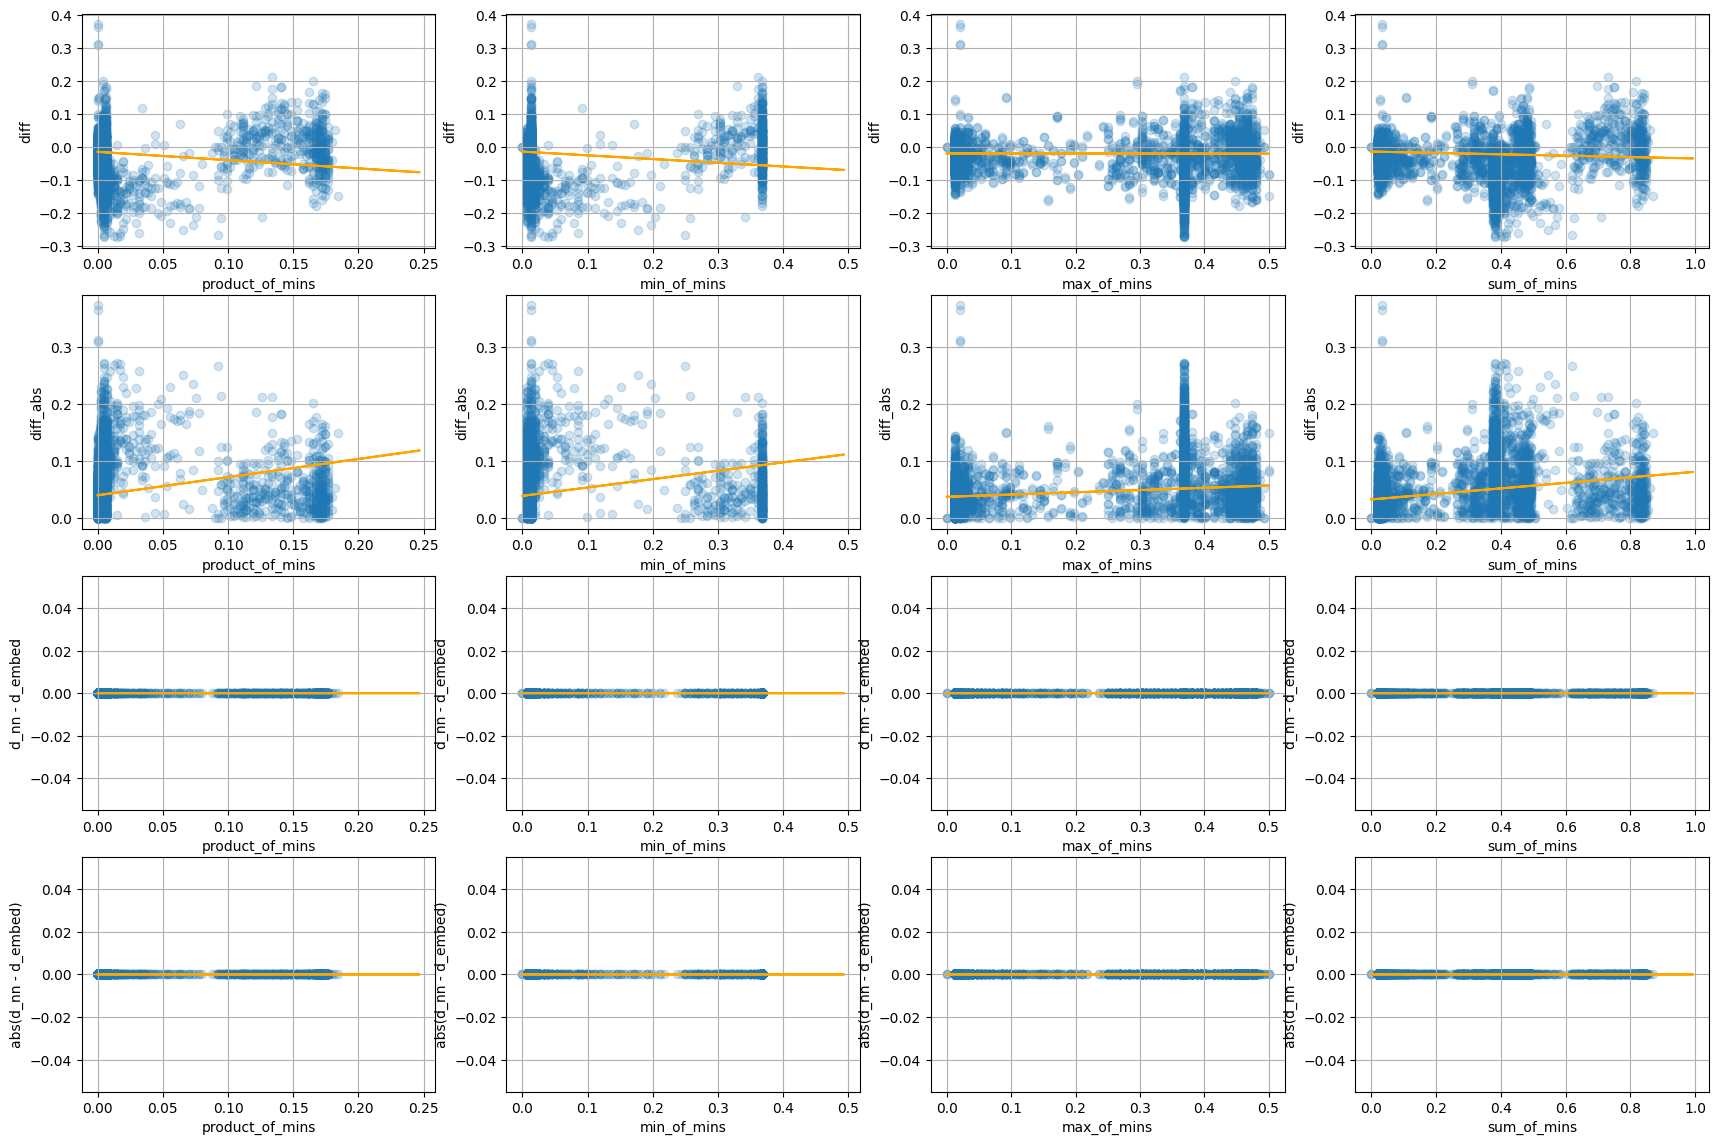

In [11]:
def linear(x, a, b):
    return a + b*x

from scipy.optimize import curve_fit
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (21, 21*2/3))
count = 0
for j, err in enumerate(["diff", "diff_abs", "d_nn - d_embed", "abs(d_nn - d_embed)"]):
    for i, element in enumerate(["product_of_mins", "min_of_mins", "max_of_mins", "sum_of_mins"]):
        x, y = get_plot_arrays(results, seq_pairs, sequence_orders, element, err)
        popt, pcov = curve_fit(linear, np.array(x), np.array(y))
        axes[count // 4, count % 4].plot(x, linear(np.array(x), *popt), color = "orange")
        axes[count // 4, count % 4].scatter(x[::500], y[::500], alpha=0.2)
        axes[count // 4, count % 4].set_xlabel(element)
        axes[count // 4, count % 4].set_ylabel(err)
        print(count // 4, count % 4)
        axes[count // 4, count % 4].grid()
        count+=1
plt.show()

* verify that the model trained
* verify that the points are not being mapped back to themselves
* verify you are 